In [ ]:
!git clone https://github.com/chrishendra93/MI_Workshop


Cloning into 'MI_Workshop'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 74 (delta 30), reused 46 (delta 16), pack-reused 0
Unpacking objects: 100% (74/74), done.


In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from tqdm.notebook import tqdm

In [ ]:
np.random.seed(0)

In [ ]:
root_dir = "/content/MI_Workshop/mnist_clr"
data_dir = "/content/MI_Workshop/lab_1"

mnist_columns = ["label"] + ["features_{}".format(i) for i in range(28 ** 2)]
mnist_train = pd.read_csv("./sample_data/mnist_train_small.csv", names=mnist_columns)
mnist_test = pd.read_csv("./sample_data/mnist_test.csv", names=mnist_columns)
mnist_arr_train = mnist_train[["features_{}".format(i) for i in range(28 ** 2)]].values
mnist_arr_test = mnist_test[["features_{}".format(i) for i in range(28 ** 2)]].values

X_train = np.load(os.path.join(root_dir, "train_features.npy"))
X_test = np.load(os.path.join(root_dir, "test_features.npy"))
y_train = np.load(os.path.join(root_dir, "train_labels.npy"))
y_test = np.load(os.path.join(root_dir, "test_labels.npy"))

print(np.all(y_train == mnist_train["label"].values))
print(np.all(y_test == mnist_test["label"].values))

train_bags, train_labels = np.load(os.path.join(data_dir, "train_bags.npy"), allow_pickle=True), np.load(os.path.join(data_dir, "train_labels.npy"),allow_pickle=True)
test_bags, test_labels = np.load(os.path.join(data_dir, "test_bags.npy"), allow_pickle=True), np.load(os.path.join(data_dir, "test_labels.npy"), allow_pickle=True)


True
True


In [ ]:
!pip install umap-learn

     |████████████████████████████████| 80 kB 3.3 MB/s 
     |████████████████████████████████| 1.1 MB 19.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76566 sha256=429e03878c1488e42f562570ce0a1caf555dc066711f1dc769cd77d323845657
  Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a8eec4dd72f
  Created wheel for pynndescent: filename=pynndescent-0.5.4-py3-none-any.whl size=52372 sha256=e3dfc882ba86766c102f7ddf1fdd201cd908afd93672312b93cf6676fc7bf027
  Stored in directory: /root/.cache/pip/wheels/d0/5b/62/3401692ddad12324249c774c4b15ccb046946021e2b581c043
Successfully built umap-learn pynndescent


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


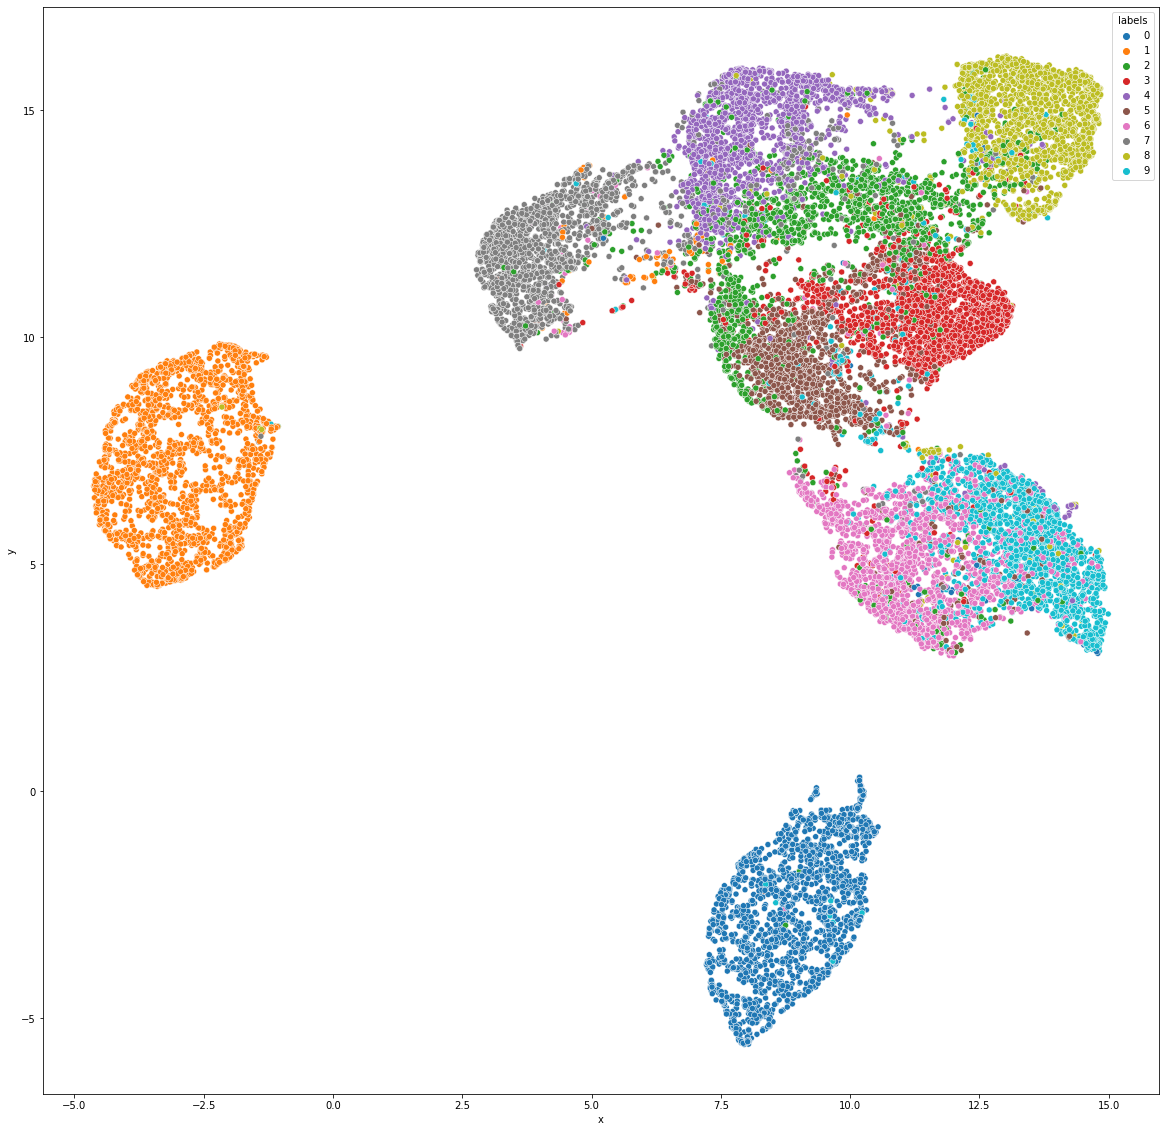

In [ ]:
from umap import UMAP

X_train_umap = UMAP().fit_transform(X_train)

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
to_plot_train = pd.DataFrame({'x': X_train_umap[:, 0].flatten(), 
                              'y': X_train_umap[:, 1].flatten(),
                              'labels': y_train})
to_plot_train["labels"] = to_plot_train["labels"].astype('category')
sns.scatterplot(x='x', y='y', data=to_plot_train, hue='labels', ax=ax)


In [ ]:
# Visualize some the loaded variables

In [ ]:
# Visualize distribution of labels in train and test sets


In [ ]:
# Visualize distribution of instances in train and test sets


In [ ]:
def visualize_bags(mnist_arr, bags, bag_labels, n_bags):
  pos_bags = np.argwhere(bag_labels == 1).flatten()
  neg_bags = np.argwhere(bag_labels == 0).flatten()
  n_pos = (n_bags // 2 )
  n_neg = n_bags - n_pos
  sampled_indices = np.concatenate([np.random.choice(pos_bags, n_pos, replace=False), np.random.choice(neg_bags, n_neg, replace=False)])
  sampled_bags = bags[sampled_indices]
  sampled_bag_labels = bag_labels[sampled_indices] 
  max_instances_num = np.max([len(bag) for bag in sampled_bags])
  _, axes = plt.subplots(len(sampled_bags), max_instances_num,
                         figsize=(10 * len(sampled_bags), 
                                  10 * max_instances_num))
  for idx, bag, bag_label in zip(np.arange(n_bags), sampled_bags, sampled_bag_labels):
    ax = axes[idx, :]
    instance_size = None
    for i in range(max_instances_num):
      if i >= len(bag):
        ax[i].imshow(np.zeros(instance_size)) # Pad with empty images if bag has fewer instances than max
      else:
        img = mnist_arr[bag[i]]
        if instance_size is None:
          w = int(np.sqrt(len(img)))
          instance_size = (w, w)
        ax[i].imshow(img.reshape(instance_size))
      if i == max_instances_num // 2:
        ax[i].set_title('Bag Label: {}'.format(bag_label), fontsize=50)
  plt.subplots_adjust(bottom=0.1, top=0.3, hspace=0.2)


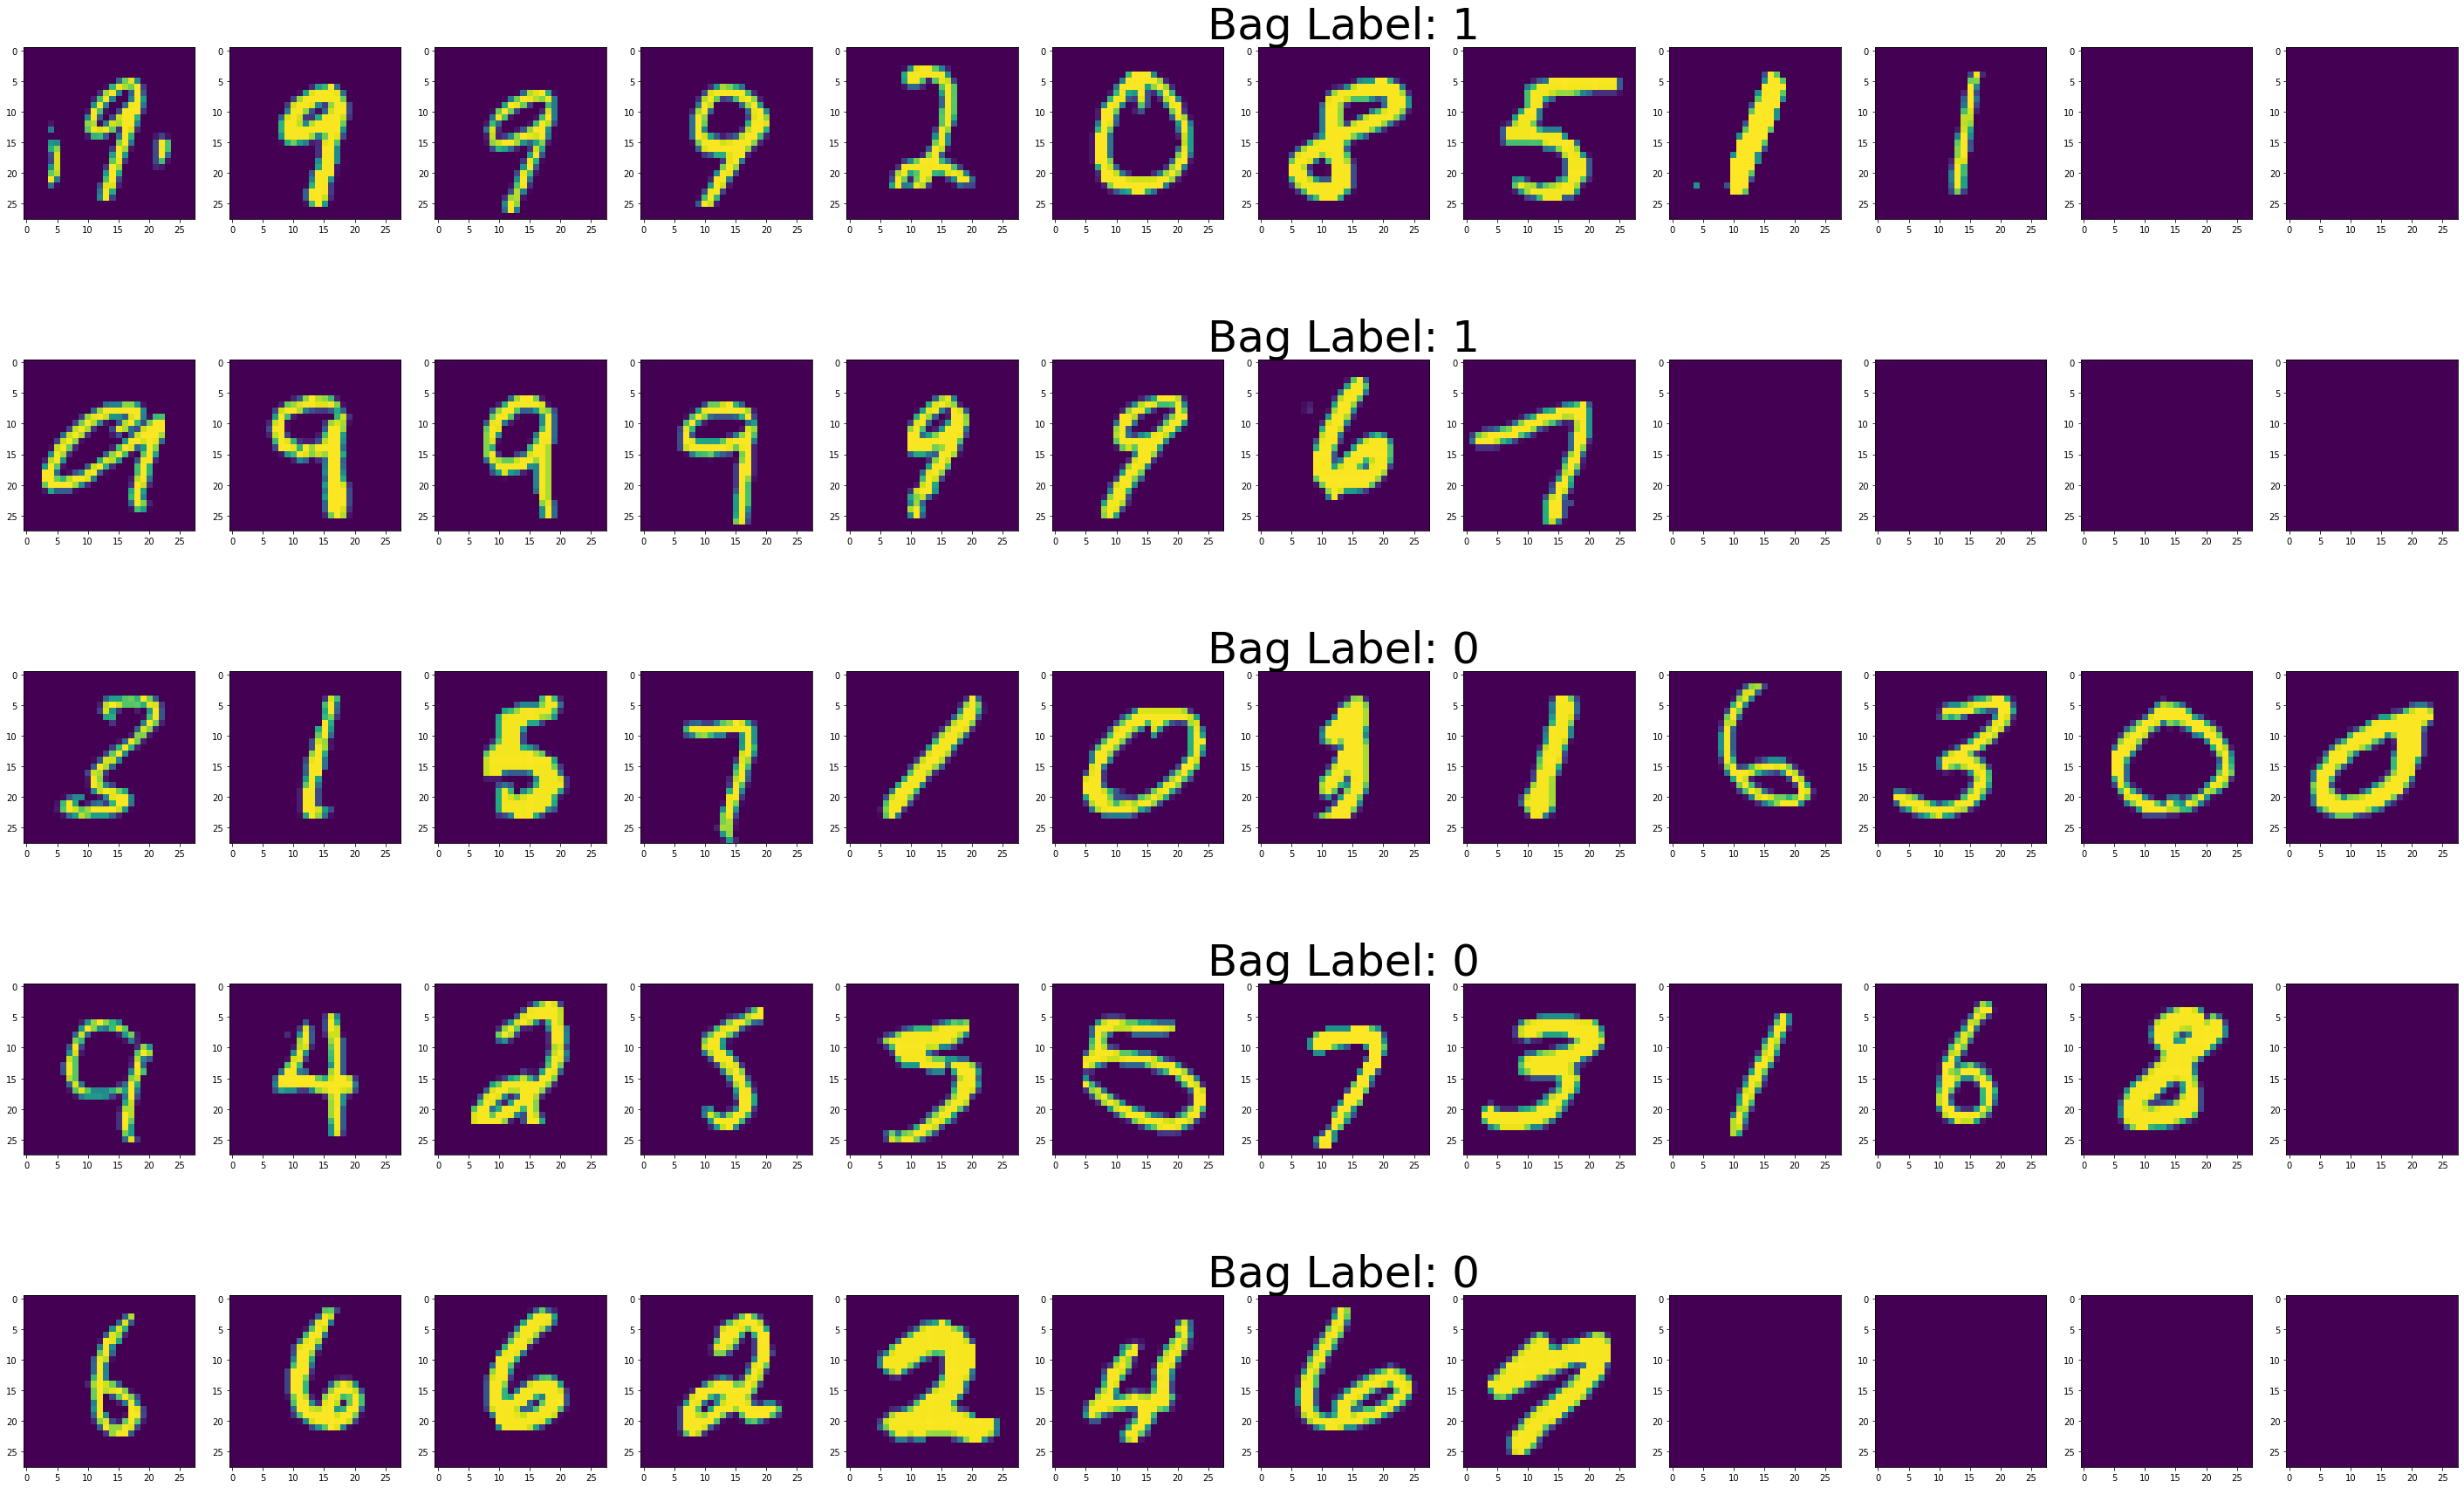

In [ ]:
visualize_bags(mnist_arr_train, train_bags, train_labels, 5)

In [ ]:
from scipy.stats import kurtosis
from functools import partial
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def extract_summary_stats(mnist_features, bags, summary_funcs=[np.mean]):
  summary_stats = []
  for summary_func in summary_funcs:
    summary_func = partial(summary_func, axis=0)
    summary_stat = np.array([summary_func(mnist_features[bag]) for bag in bags]).reshape(-1, 64)
    summary_stats.append(summary_stat)
  return np.concatenate(summary_stats, axis=1)

In [ ]:
X_train_stats = extract_summary_stats(X_train, train_bags, [np.mean, np.var, kurtosis])
X_test_stats = extract_summary_stats(X_test, test_bags, [np.mean, np.var, kurtosis])

In [ ]:
# Run PCA after standardizing the extracted summary statistics features


In [ ]:
# Visualize distribution of instances in train and test sets

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
to_plot_train = pd.DataFrame({'x': X_train_pca[:, 0].flatten(), 
                              'y': X_train_pca[:, 1].flatten(),
                              'labels': train_labels})
to_plot_train["labels"] = to_plot_train["labels"].astype('category')
sns.scatterplot(x='x', y='y', data=to_plot_train, hue='labels', ax=ax)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_curve, precision_recall_curve, auc
from scipy.stats import mode

In [ ]:
def get_roc_auc(y_true, y_pred):
    fpr, tpr, _  = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    return roc_auc


def get_pr_auc(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred, pos_label=1)
    pr_auc = auc(recall, precision)
    return pr_auc


def get_accuracy(y_true, y_pred):
    return balanced_accuracy_score(y_true, y_pred)

In [ ]:
# Try out simple classification using Logistic regression on the mean variables


In [ ]:
# summary_statistics_list = {'mean': [np.mean], 'var': [np.var], 'kurtosis': [kurtosis],
#                            'mean_var': [np.mean, np.var], 'mean_kurtosis': [np.mean, kurtosis], 'var_kurtosis': [np.var, kurtosis],
#                            'mean_var_kurtosis': [np.mean, np.var, kurtosis]}

# df = []
# for summary_statistics, stats_func in summary_statistics_list.items():

#   X_train_stats = extract_summary_stats(X_train, train_bags, stats_func)
#   X_test_stats = extract_summary_stats(X_test, test_bags, stats_func)
#   model = LogisticRegression(max_iter=10000).fit(X_train_stats, train_labels)
#   y_test_pred = model.predict(X_test_stats)
#   balanced_accuracy = balanced_accuracy_score(test_labels, y_test_pred)
#   roc_auc = get_roc_auc(test_labels, y_test_pred)
#   pr_auc = get_pr_auc(test_labels, y_test_pred)
#   df += [(summary_statistics, roc_auc, pr_auc, balanced_accuracy)]

# df = pd.DataFrame(df, columns=['Model', 'ROC AUC', 'PR AUC', 'Balanced Accuracy']).sort_values("Balanced Accuracy", ascending=False)
# df

Remember the Hausdorff distance between two sets (bags) $X$ and $Y$ is given by:
$$H(X,Y) = \max\{h(A, B), h(B, A)\}$$
$$h(A,B) = \max_{a \in A}\min_{b \in B}d(a,b)$$

We also have some variations of the Hausdorff distance, for example the minimum Hausdorff distance:
$$h(A,B) = \min_{a \in A}\min_{b \in B}d(a,b)$$

or the average Hausdorff distance
$$H(A,B) = \frac{\sum_{a \in A}\min_{b \in B}d(a,b) + \sum_{b \in B}\min_{a \in A} d(a,b)}{|A| + |B|}$$

where $d$ is any metric function. Here we are going to implement Hausdorff distance using the Euclidean metric

In [ ]:
from sklearn.metrics import pairwise_distances

def get_hausdorff_distance(X_train, X_test, train_bags, test_bags, mode='max', quantile=0.7):
  pairwise_distance = pairwise_distances(X_test, X_train)
  all_bag_distances = []
  
  for test_bag in tqdm(test_bags, total=len(test_bags)):
    test_bag_instances = pairwise_distance[test_bag]
    bag_distances = []

    for train_bag in train_bags:
      if mode == 'max':
        test_train_distance = np.max(np.min(test_bag_instances[:, train_bag], axis=1))
        train_test_distance = np.max(np.min(test_bag_instances[:, train_bag].transpose(), axis=1))
        bag_distances.append(max(test_train_distance, train_test_distance))
      
      elif mode =='avg':
        test_train_distance = np.min(test_bag_instances[:, train_bag], axis=1)
        train_test_distance = np.min(test_bag_instances[:, train_bag].transpose(), axis=1)
        bag_distances.append(np.mean(np.concatenate([train_test_distance, test_train_distance])))
      
      elif mode == 'min':
        test_train_distance = np.min(np.min(test_bag_instances[:, train_bag], axis=1))
        train_test_distance = np.min(np.min(test_bag_instances[:, train_bag].transpose(), axis=1))
        bag_distances.append(max(test_train_distance, train_test_distance))
      elif mode == 'quantile':
        test_train_distance = np.quantile(np.min(test_bag_instances[:, train_bag], axis=1), quantile)
        train_test_distance = np.quantile(np.min(test_bag_instances[:, train_bag].transpose(), axis=1), quantile)
        bag_distances.append(max(test_train_distance, train_test_distance))
    all_bag_distances.append(np.array(bag_distances).reshape(1, -1))
  all_bag_distances = np.concatenate(all_bag_distances, axis=0)
  return all_bag_distances


In [ ]:
# Compute hausdorff distances between bag using max, average, and minimum

bag_distances_max = get_hausdorff_distance(X_train, X_test, train_bags, test_bags, mode='max')
bag_distances_avg = get_hausdorff_distance(X_train, X_test, train_bags, test_bags, mode='avg')
bag_distances_min = get_hausdorff_distance(X_train, X_test, train_bags, test_bags, mode='min')
# bag_distances_q07 = get_hausdorff_distance(X_train, X_test, train_bags, test_bags, mode='quantile', quantile=0.7)
# bag_distances_q08 = get_hausdorff_distance(X_train, X_test, train_bags, test_bags, mode='quantile', quantile=0.8)

In [ ]:
from scipy.stats import mode

def get_knn_pred(train_labels, test_labels, all_bag_distances, n_neighbors):
  return mode(train_labels[np.argsort(all_bag_distances, axis=1)[:, :n_neighbors]], axis=1)[0].flatten()


def get_citation_knn_pred(train_labels, test_labels, all_bag_distances, n_ref_neighbors=10, n_cit_neighbors=10):
  reference_nn = train_labels[np.argsort(all_bag_distances, axis=1)[:, :n_ref_neighbors]]
  num_pos_neighbors = np.sum(reference_nn, axis=1)
  num_neg_neighbors = n_ref_neighbors - num_pos_neighbors
  reference_nn_labels = np.concatenate([num_neg_neighbors.reshape(-1, 1),
                                        num_pos_neighbors.reshape(-1, 1)], axis=1)
  citer_nn_labels = get_citation_counts(train_labels, test_labels, all_bag_distances, n_cit_neighbors)
  return reference_nn_labels + citer_nn_labels

def get_citation_counts(train_labels, test_labels, all_bag_distances, n_neighbors):
  test_pos_neg_counts = np.zeros((len(test_labels), 2))
  nn = np.argsort(all_bag_distances.transpose(), axis=1)[:, :n_neighbors]
  for citer in range(len(nn)):
    citations = nn[citer]
    citer_label = np.array([0, 1]) if train_labels[citer] == 1 else np.array([1, 0])
    for citation in citations:
      test_pos_neg_counts[citation, :] += citer_label
  return test_pos_neg_counts






In [ ]:
# Run KNN algorithm from the pre-computed bag distances 

In [ ]:
# Run citation KNN algorithm from the pre-computed bag distances 

In [ ]:
def get_citation_knn_pred_normalized(train_labels, test_labels, all_bag_distances, n_ref_neighbors=10, n_cit_neighbors=10):
  reference_nn = train_labels[np.argsort(all_bag_distances, axis=1)[:, :n_ref_neighbors]]
  num_pos_neighbors = np.sum(reference_nn, axis=1)
  num_neg_neighbors = n_ref_neighbors - num_pos_neighbors
  reference_nn_labels = np.concatenate([num_neg_neighbors.reshape(-1, 1),
                                        num_pos_neighbors.reshape(-1, 1)], axis=1)
  citer_nn_labels = get_citation_counts(train_labels, test_labels, all_bag_distances, n_cit_neighbors)
  return reference_nn_labels / np.sum(reference_nn_labels, axis=0) + citer_nn_labels / np.sum(citer_nn_labels, axis=0)

In [ ]:
# Run the normalized version of citation KNN algorithm from the pre-computed bag distances

In [ ]:
## Run the normalzied version of cKNN algorithm and KNN and tabulate them for several of the metrics 

# n_neighbors_ref = 15
# n_neighbors_cit = 5

# df_knn = []

# for distance_mode, distance in zip(['max', 'avg', 'min'], 
#                           [bag_distances_max, bag_distances_avg, bag_distances_min, bag_distances_q07, bag_distances_q08]):
#   y_pred_test_knn = get_knn_pred(train_labels, test_labels, distance, n_neighbors_ref)
#   balanced_acc = balanced_accuracy_score(test_labels, y_pred_test_knn)
#   df_knn += [(distance_mode, balanced_acc)]
# df_knn = pd.DataFrame(df_knn, columns=['Distance Type', 'Balanced Accuracy']).sort_values("Balanced Accuracy", ascending=False)

# df_cknn = []

# for distance_mode, distance in zip(['max', 'avg', 'min'
], 
#                           [bag_distances_max, bag_distances_avg, bag_distances_min, bag_distances_q07, bag_distances_q08]):
#   y_pred_test_knn = np.argmax(get_citation_knn_pred_normalized(train_labels, test_labels, distance, n_neighbors_ref, n_neighbors_cit), axis=1)
#   balanced_acc = balanced_accuracy_score(test_labels, y_pred_test_knn)
#   df_cknn += [(distance_mode, balanced_acc)]
# df_cknn = pd.DataFrame(df_cknn, columns=['Distance Type', 'Balanced Accuracy']).sort_values("Balanced Accuracy", ascending=False)

# df = df_knn.merge(df_cknn, on=["Distance Type"], suffixes=['_knn', '_cknn'])
# df